# Train model for task 1

In [1]:
import keras

from keras import backend as K
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout,Input
from keras.layers import Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D, BatchNormalization  
from keras_preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

import os
import cv2
import time
import json
import random
from PIL import Image
import h5py as h5py
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

## 1. Visualize data

In [2]:
train_file = pd.read_csv('../input/1-task/train.csv')
test_file = pd.read_csv('../input/1-task/test.csv')
validation_file = pd.read_csv('../input/1-task/validation.csv')

In [3]:
niCT = np.array(train_file['path'][train_file['type']=='niCT'])
nCT = np.array(train_file['path'][train_file['type']=='nCT'])
pCT = np.array(train_file['path'][train_file['type']=='pCT'])
print('There are {:0} niCT, {:0} nCT, and {:0} pCT'.format(len(niCT),len(nCT),len(pCT)))

There are 4588 niCT, 8114 nCT, and 3242 pCT


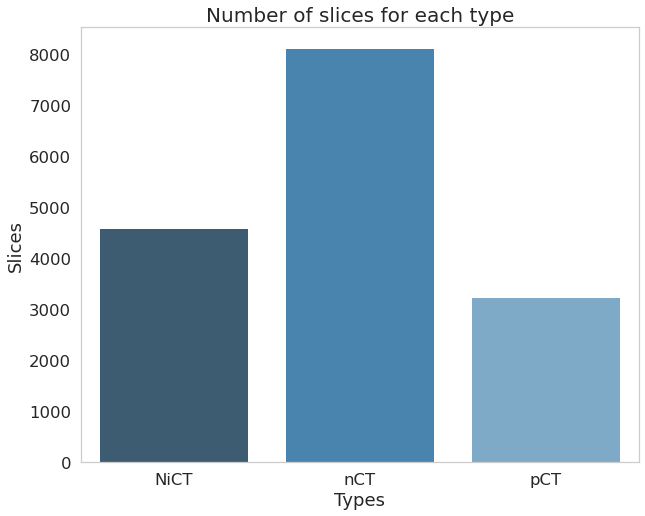

In [4]:
plt.figure(figsize=(10,8))
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.barplot(x=['NiCT','nCT','pCT'], y=[len(niCT),len(nCT),len(pCT)],palette="Blues_d")
plt.title('Number of slices for each type', fontsize=20)

plt.xlabel('Types', fontsize=18)
plt.ylabel('Slices', fontsize=18)
plt.show()

## Imbalanced data

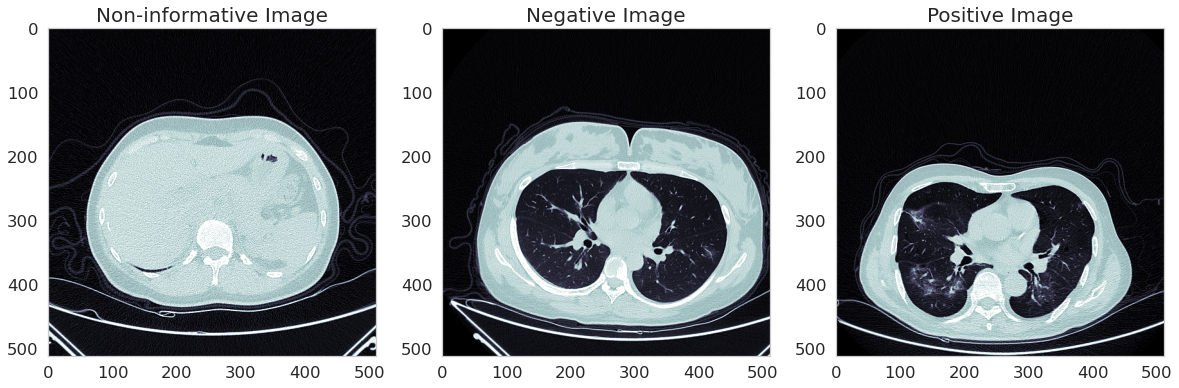

In [5]:
fig= plt.figure(figsize=(20,10))

path = '../input/preprocessed-ct-scans-for-covid19/Original CT Scans/' + niCT[5]
img = np.array(Image.open(path).convert('L'),dtype=np.float32)/255
a= fig.add_subplot(1,3,1)
a.set_title('Non-informative Image',fontsize=20)
plt.imshow(img,cmap='bone')

path = '../input/preprocessed-ct-scans-for-covid19/Original CT Scans/' + nCT[0]
img = np.array(Image.open(path).convert('L'),dtype=np.float32)/255
a= fig.add_subplot(1,3,2)
a.set_title('Negative Image',fontsize=20)
plt.imshow(img,cmap='bone')

path = '../input/preprocessed-ct-scans-for-covid19/Original CT Scans/' + pCT[0]
img = np.array(Image.open(path).convert('L'),dtype=np.float32)/255
a= fig.add_subplot(1,3,3)
a.set_title("Positive Image",fontsize=20)
plt.imshow(img,cmap='bone');

## 2. Data pre-processing and augmentation


In [6]:
#def random_crop(img, crop_size):
 #   """Randomly crops an image of a given size.
  #  """
   # assert img.shape[2] == 1
   # height, width = img.shape[0], img.shape[1]
   # dy, dx = crop_size
   # x = np.random.randint(0, width - dx + 1)
   # y = np.random.randint(0, height - dy + 1)
   # return img[y:(y+dy), x:(x+dx), :]


#def aug_2():
 #   pass


#def further_augment(batches, size):
 #   """Take as input a Keras ImageGen (Iterator) and add our own augmentation, including
 #   random_crop, 
 #   to the image batches generated by the original iterator.
 #   """
 #   while True:
  #      batch_x, batch_y = next(batches)
   #     batch_crops = np.zeros((batch_x.shape[0], size, size, 1))
   #     for i in range(batch_x.shape[0]):
    #        ...
     #       ...
     #       ...
     #       batch_crops[i] = random_crop(batch_x[i], (size, size))
     #   yield (batch_crops, batch_y)'''''

In [7]:
train_gen = ImageDataGenerator(
        rescale=1./255,
#         rotation_range=20,
#         vertical_flip=True,
#        horizontal_flip=True
)
train_batches = train_gen.flow_from_dataframe(dataframe=train_file, 
                                            directory="../input/preprocessed-ct-scans-for-covid19/Original CT Scans/", 
                                            x_col="path", 
                                            y_col="type", 
                                            batch_size=32,
                                            target_size=(256,256),
                                            class_mode="categorical")
# train_batches = further_augment(train_batches, 400)

val_gen = ImageDataGenerator(rescale=1./255)
val_batches = val_gen.flow_from_dataframe(dataframe=validation_file, 
                                            directory="../input/preprocessed-ct-scans-for-covid19/Original CT Scans/", 
                                            x_col="path", 
                                            y_col="type", 
                                            batch_size=32,
                                            shuffle=False,
                                            target_size=(256,256),
                                            class_mode="categorical")

test_gen = ImageDataGenerator(rescale=1./255)
test_batches = test_gen.flow_from_dataframe(dataframe=test_file, 
                                            directory="../input/preprocessed-ct-scans-for-covid19/Original CT Scans/", 
                                            x_col="path", 
                                            y_col="type", 
                                            batch_size=32,
                                            target_size=(256,256),
                                            class_mode=None)

Found 15944 validated image filenames belonging to 3 classes.
Found 1772 validated image filenames belonging to 3 classes.
Found 1969 validated image filenames.


## Fix imbalanced data

In [8]:
weight_for_0 = (1 / 4588)*(15944)/3.0 
weight_for_1 = (1 / 8114)*(15944)/3.0
weight_for_2 = (1 / 3242)*(15944)/3.0
class_weights = {0: weight_for_1, 1: weight_for_0, 2:weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 1.16
Weight for class 1: 0.65
Weight for class 2: 1.64


In [9]:
#weight_for_0 = (1 / 4588)*(15944)/3.0 
#weight_for_1 = (1 / 8114)*(15944)/3.0
#weight_for_2 = (1 / 3242)*(15944)/3.0
#weight_for_2 = weight_for_2*2
#class_weights = {0: weight_for_1, 1: weight_for_0, 2:weight_for_2}

#print('Weight for class 0: {:.2f}'.format(weight_for_1))
#print('Weight for class 1: {:.2f}'.format(weight_for_0))
#print('Weight for class 2: {:.2f}'.format(weight_for_2))

## Model

In [10]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(256,256,3)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))


model.summary()

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 250, 250, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 125, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 123, 123, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 121, 121, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 128)       0

In [11]:
#model.compile(loss=keras.losses.categorical_crossentropy,
#              optimizer=keras.optimizers.Adadelta(learning_rate = 0.01),
#              metrics=['accuracy'])

#early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=10)


#epochs = 15

#history = model.fit(train_batches,
#          epochs=epochs,
#          verbose=1,
#          callbacks=[early_stopping_monitor],
#          class_weight=class_weights,
#          validation_data=val_batches) 

In [12]:
#trial = 'newmodel4'

#statistics = {'train':(train_loss,train_acc), 'eval':(val_loss,val_acc)}
#json.dump(statistics, open(trial+'.json', 'w'))
#model.save_weights(trial+'.h5')

## Use the new class weights

In [13]:
model.load_weights('../input/finalweights/actualweights.h5')


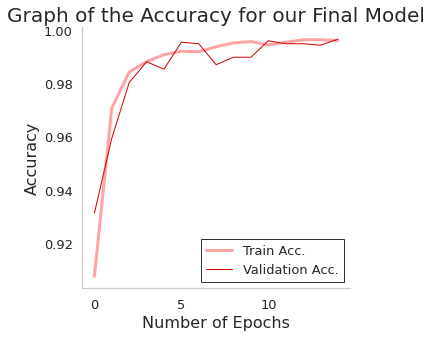

In [14]:
p1 = json.load(open('../input/finalweights/actualweights.json'))

fig, ax = plt.subplots(figsize=(4.8,4.8))
plt.plot(np.arange(0,15), p1['train'][1],'#FFA3A3',linewidth = 3, label = 'Train Acc.')
plt.plot(np.arange(0,15), p1['eval'][1],'#D20000',linewidth = 1, label = 'Validation Acc.')
plt.title('Graph of the Accuracy for our Final Model', fontsize=20)
plt.xlabel('Number of Epochs',{'weight': 350,'size': 16})
plt.ylabel('Accuracy',{'weight': 350,'size': 16})

plt.legend(edgecolor='black',fancybox= False,fontsize=13);

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_size(13) for label in labels]

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

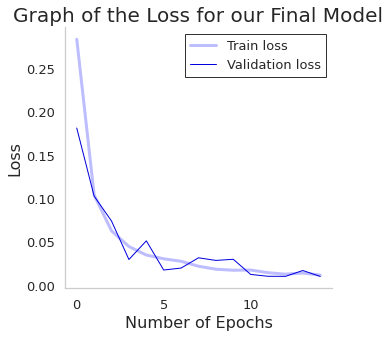

In [15]:
p1 = json.load(open('../input/finalweights/actualweights.json'))

fig, ax = plt.subplots(figsize=(4.8,4.8))
plt.plot(np.arange(0,15), p1['train'][0],'#BDBDFF',linewidth = 3, label = 'Train loss')
plt.plot(np.arange(0,15), p1['eval'][0],'#0000DE',linewidth = 1, label = 'Validation loss')
plt.title('Graph of the Loss for our Final Model', fontsize=20)
plt.xlabel('Number of Epochs',{'weight': 350,'size': 16})
plt.ylabel('Loss',{'weight': 350,'size': 16})

plt.legend(edgecolor='black',fancybox= False,fontsize=13);

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_size(13) for label in labels]

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

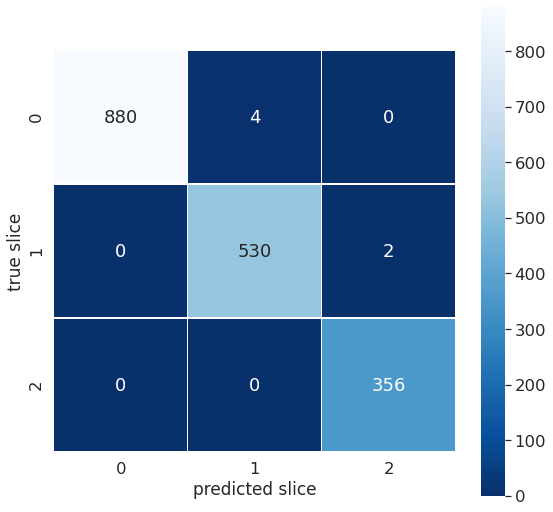

In [16]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(val_batches, 1772// 32+1)
y_pred = np.argmax(Y_pred, axis=1)
cm=confusion_matrix(val_batches.classes, y_pred)
plt.figure(figsize=(9,9))
#cmap = sns.diverging_palette(220,10,center = "light", as_cmap=True)
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
#sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap=cmap)
plt.ylabel('true slice', size=17)
plt.xlabel('predicted slice', size=17)
plt.show()

## Compare it with the model without fixing the class weights

In [17]:
model.load_weights('../input/finalweights/withoutweights.h5')

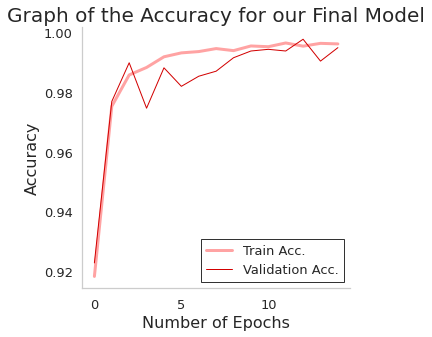

In [18]:
p1 = json.load(open('../input/finalweights/withoutweights.json'))

fig, ax = plt.subplots(figsize=(4.8,4.8))
plt.plot(np.arange(0,15), p1['train'][1],'#FFA3A3',linewidth = 3, label = 'Train Acc.')
plt.plot(np.arange(0,15), p1['eval'][1],'#D20000',linewidth = 1, label = 'Validation Acc.')
plt.title('Graph of the Accuracy for our Final Model', fontsize=20)
plt.xlabel('Number of Epochs',{'weight': 350,'size': 16})
plt.ylabel('Accuracy',{'weight': 350,'size': 16})

plt.legend(edgecolor='black',fancybox= False,fontsize=13);

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_size(13) for label in labels]

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

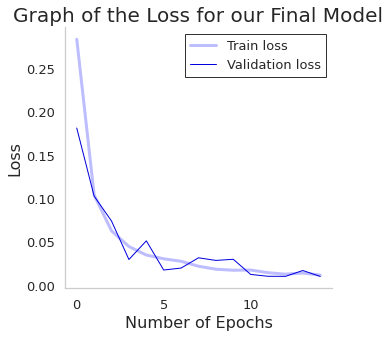

In [19]:
p1 = json.load(open('../input/finalweights/actualweights.json'))

fig, ax = plt.subplots(figsize=(4.8,4.8))
plt.plot(np.arange(0,15), p1['train'][0],'#BDBDFF',linewidth = 3, label = 'Train loss')
plt.plot(np.arange(0,15), p1['eval'][0],'#0000DE',linewidth = 1, label = 'Validation loss')
plt.title('Graph of the Loss for our Final Model', fontsize=20)
plt.xlabel('Number of Epochs',{'weight': 350,'size': 16})
plt.ylabel('Loss',{'weight': 350,'size': 16})

plt.legend(edgecolor='black',fancybox= False,fontsize=13);

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_size(13) for label in labels]

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

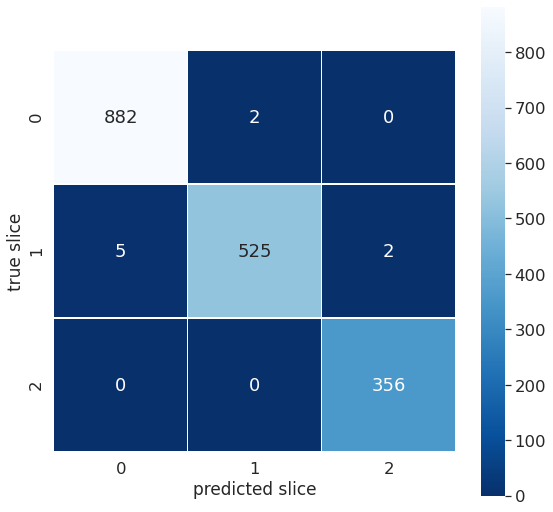

In [20]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(val_batches, 1772// 32+1)
y_pred = np.argmax(Y_pred, axis=1)
cm=confusion_matrix(val_batches.classes, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('true slice', size=17)
plt.xlabel('predicted slice', size=17)
plt.show()

We tried to double the class weight for positive slices to see if the accuracy and loss graphs and confusion matrix changes

In [21]:
model.load_weights('../input/finalweights/resultswithout2times.h5')

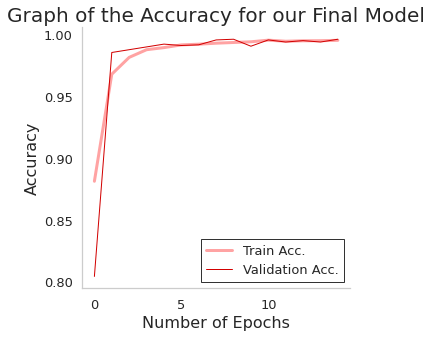

In [22]:
p1 = json.load(open('../input/finalweights/resultswithout2times.json'))

fig, ax = plt.subplots(figsize=(4.8,4.8))
plt.plot(np.arange(0,15), p1['train'][1],'#FFA3A3',linewidth = 3, label = 'Train Acc.')
plt.plot(np.arange(0,15), p1['eval'][1],'#D20000',linewidth = 1, label = 'Validation Acc.')
plt.title('Graph of the Accuracy for our Final Model', fontsize=20)
plt.xlabel('Number of Epochs',{'weight': 350,'size': 16})
plt.ylabel('Accuracy',{'weight': 350,'size': 16})

plt.legend(edgecolor='black',fancybox= False,fontsize=13);

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_size(13) for label in labels]

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

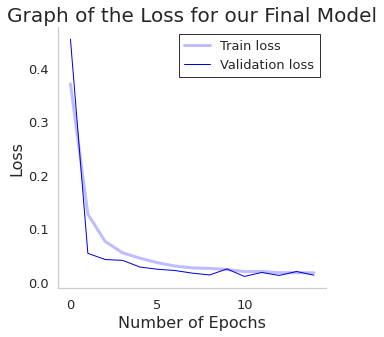

In [23]:
p1 = json.load(open('../input/finalweights/resultswithout2times.json'))

fig, ax = plt.subplots(figsize=(4.8,4.8))
plt.plot(np.arange(0,15), p1['train'][0],'#BDBDFF',linewidth = 3, label = 'Train loss')
plt.plot(np.arange(0,15), p1['eval'][0],'#0000DE',linewidth = 1, label = 'Validation loss')
plt.title('Graph of the Loss for our Final Model', fontsize=20)
plt.xlabel('Number of Epochs',{'weight': 350,'size': 16})
plt.ylabel('Loss',{'weight': 350,'size': 16})

plt.legend(edgecolor='black',fancybox= False,fontsize=13);

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_size(13) for label in labels]

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

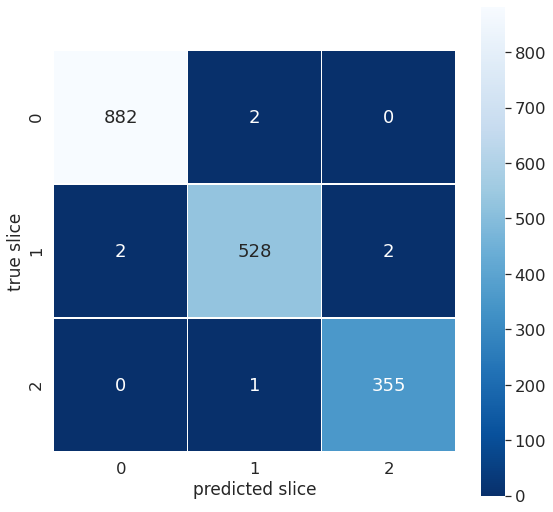

In [24]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
Y_pred = model.predict_generator(val_batches, 1772// 32+1)
y_pred = np.argmax(Y_pred, axis=1)
cm=confusion_matrix(val_batches.classes, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('true slice', size=17)
plt.xlabel('predicted slice', size=17)
plt.show()

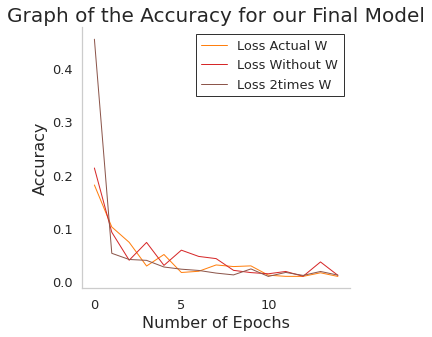

In [25]:
p1 = json.load(open('../input/finalweights/actualweights.json'))
p2 = json.load(open('../input/finalweights/withoutweights.json'))
p3 = json.load(open('../input/finalweights/resultswithout2times.json'))
fig, ax = plt.subplots(figsize=(4.8,4.8))
#plt.plot(np.arange(0,15), p1['train'][1],'#FFA3A3',linewidth = 3, label = 'Train Acc. Actual W')
plt.plot(np.arange(0,15), p1['eval'][0],'#ff7f0e',linewidth = 1, label = 'Loss Actual W')
#plt.plot(np.arange(0,15), p2['train'][1],'#BDBDFF',linewidth = 3, label = 'Train Acc. Without W')
plt.plot(np.arange(0,15), p2['eval'][0],'#d62728',linewidth = 1, label = 'Loss Without W')
#plt.plot(np.arange(0,15), p3['train'][1],'#FFA3A3',linewidth = 3, label = 'Train Acc. 2times W')
plt.plot(np.arange(0,15), p3['eval'][0],'#8c564b',linewidth = 1, label = 'Loss 2times W')
plt.title('Graph of the Accuracy for our Final Model', fontsize=20)
plt.xlabel('Number of Epochs',{'weight': 350,'size': 16})
plt.ylabel('Accuracy',{'weight': 350,'size': 16})

plt.legend(edgecolor='black',fancybox= False,fontsize=13);

labels = ax.get_xticklabels() + ax.get_yticklabels()
[label.set_size(13) for label in labels]

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)